# IMPORT

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
#import statistics
from mpl_toolkits.mplot3d import Axes3D
import time
from datetime import datetime, timedelta
import warnings
from sklearn.model_selection import train_test_split
#from sklearn.naive_bayes import GaussianNB
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn import tree
warnings.filterwarnings("ignore")
import scipy.stats as st
#import statsmodels.tsa.arima_model
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
import seaborn as sns
#import random
from collections import Counter
import math

#from imblearn.pipeline import Pipeline as ImbalancePipeline
from imblearn.combine import *
from imblearn.over_sampling import *
#from imblearn.under_sampling import RandomUnderSampler 

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
import imblearn
print('The imblearn version is {}.'.format(imblearn.__version__))

import pywt
from scipy.stats import zscore
from scipy.spatial.distance import cdist
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import shap
import csv
from random import randint, seed
from scipy.interpolate import interp1d

The scikit-learn version is 1.3.2.
The imblearn version is 0.12.3.


# FONCTIONS

In [2]:
def exclude_df(df,df_to_not_check):
    # Use function merge with how='outer'
    merged_df = pd.merge(df, df_to_not_check, how='outer', on=['cow', 'date'], indicator=True)

    # Filter rows where there isn't correspondance between DataFrames
    result_df = merged_df[merged_df['_merge'] == 'left_only']

    # Suppress "_merge"
    return result_df.drop('_merge', axis=1)

In [3]:
def remove_incomplete_day(rawdata):
    """Supprimer les donnees des jours incomplets"""
    cows = rawdata['cow'].unique()

    rmdatecow = []
    for cow in cows:
        datacow = rawdata[rawdata['cow']==cow]
        dates = datacow['date'].unique()

        for d in dates:
            if sum(datacow['date']==d) < 24:
                rmdatecow.append((cow,d))



    return exclude_df(rawdata,pd.DataFrame(rmdatecow,columns=['cow','date']))

## Create fuzzy rules

In [4]:
datasets = {'LongHealth':"../Data/dataset1-1.csv",
            'SARA':"../Data/dataset2-1.csv",
            'oestrus':"../Data/dataset3-1.csv",
            'Bill':"../Data/dataset4-1.csv"}
#TMP
#datasets = {'LongHealth':"../Data/dataset1-1.csv"}
labels = np.array(['oestrus','calving','lameness','mastitis','LPS','acidosis','other_disease', 'accidents','disturbance','mixing','management_changes','OK'])

fuzzy_rules = {'oestrus':[-1,2],
               'calving':[-2,7],
               'lameness':[-2,7],
               'mastitis':[-2,7],
               'LPS':[0,7],
               'acidosis':[0,1],
               'other_disease':[-2,7],
               'accidents':[0,7],
               'disturbance':[0,0],
               'mixing':[0,7],
               'management_changes':[0,0]}

In [5]:
def label_to_bin(label):
    n = len(labels)
    res = 0
    for i in range(n):
        if labels[n-i-1] in label:
            res+=2**i
    return res

def states_to_label(states):
    return labels[[bit == 1 for bit in states]]

def bin_to_label(bin):
    bit_list = list('{0:0{width}b}'.format(bin,width=len(labels)))
    int_list = list(map(int,bit_list))
    return states_to_label(int_list)

def maxinterval(I1,I2):
    return [min(I1[0],I2[0]),max(I1[1],I2[1])]

def getfuzzyrule(row):
    # Obtain the fuzzy rules associated for a row (a row can have more than one anomaly)
    fuz = [0,0]
    for s in labels[:-1]:
        if row[s]==1:
            fuz = maxinterval(fuz,fuzzy_rules[s])
    return fuz

def getfuzzydays(row):
    # Obtain the fuzzy days associated for a row
    fuzzyrule = getfuzzyrule(row)
    date = pd.to_datetime(row["date"])
    return [date + timedelta(days=i) for i in range(fuzzyrule[0],fuzzyrule[1]+1) if i!=0]

def getfuzzydata(data):

    abn_data = data[data["OK"]!=1][['cow','date']+labels.tolist()].drop_duplicates()

    fuzzy_data = []
    nabn = abn_data.shape[0]

    for i in range(nabn):
        row = abn_data.iloc[i,:]
        fuzzydays = getfuzzydays(row)
        m = len(fuzzydays)
        for j in range(m):
            fuzzy_data.append((row['cow'],fuzzydays[j].strftime('%Y-%m-%d')))

    return fuzzy_data

# WAVELET

In [6]:
def decomposition(signal,waveletname,level_approximation,level_decomposition_max=None):
    """Decomposition d'un signal par la transformee en ondelette discrete
    - signal : signal a decomposer
    - waveletname : ondelette utilisee pour la transformation
    - level_approximation : niveau d'approximation souhaite
    - level_decomposition_max : niveau d'approximation maximum possible"""
    if level_decomposition_max == None:
        i = len(signal.shape)
        level_decomposition_max = pywt.dwt_max_level(signal.shape[i-1],waveletname)
        
    level_reconstruction = level_decomposition_max - level_approximation
    coeffs = pywt.wavedec(signal, waveletname, level=level_decomposition_max)
    coeffs = coeffs[:level_reconstruction+1]
    return pywt.waverec(coeffs, waveletname)

In [7]:
# waveletnames = ['haar','db2','db3','bior1.3','bior2.2','bior3.1','rbio2.2','rbio3.1','coif1'] # Liste des ondelettes disponibles
# waveletname = waveletnames[1] #ondelette daubechies 2

# #dec_len = pywt.Wavelet(waveletname).dec_len # Longueur du decodeur

# level_decomposition_max = pywt.dwt_max_level(24,waveletname);

# level_approximation = 3
# level_reconstruction = level_decomposition_max - level_approximation

# print("Decomposition wavelet {}\nlevel max of approximation : {}".format(waveletname,level_decomposition_max))

# #Xdwt = decomposition(np.stack(data_AR['AR'].values),waveletname,level_decomposition_max,1)

# mean_data_h = np.mean(data_train[(data_train['OK']==1) & (data_train['is_fuzzy']==0)]['AR'].values)

# zmean = zscore(decomposition(mean_data_h,waveletname,level_decomposition_max,1))
# zmean = np.reshape(zmean,(1,zmean.shape[0]))
# zscoredwt = zscore(Xdwt)
# alldist=cdist(zscoredwt,zmean)
# #math.dist(zscore(X_DWT_Bill[0,:]),zmean)

# std_data_h = np.std(vars()[nameXdwt][y_Bill=='OK',:], axis=0)
# comparaison_fun = lambda X : compare_with_mean(X,mean_data_h,std_data_h)

# mean_data_oestrus = np.mean(vars()[nameXdwt][y_Bill=='oestrus',:], axis=0)
# std_data_oestrus = np.std(vars()[nameXdwt][y_Bill=='oestrus',:], axis=0)


# # Tracé de la courbe moyenne avec l'écart-type sous forme de tube
# plt.plot(mean_data_h, color='blue', label='Moyenne')
# plt.plot(mean_data_oestrus, color='red', label='Moyenne')
# plt.plot(X_DWT_Bill[0,:])
# plt.fill_between(range(vars()[nameXdwt].shape[1]), mean_data_h - std_data_h, mean_data_h + std_data_h, color='lightblue', alpha=0.5, label='Écart-type')
# plt.fill_between(range(vars()[nameXdwt].shape[1]), mean_data_oestrus - std_data_oestrus, mean_data_oestrus + std_data_oestrus, color='pink', alpha=0.5, label='Écart-type')
# plt.xlabel('Index')
# plt.ylabel('Valeur')
# plt.title('Courbe moyenne avec écart-type')
# plt.legend()
# plt.show()

# distance_to_mean_std = (X_DWT_Bill - mean_data) / std_data

# plt.show()

# ATTRIBUTES

In [8]:
def remove_outliers(data):

    AR = np.reshape(data["ACTIVITY_LEVEL"],(-1,24))
    uniquecowsdates = data[['cow','date']].drop_duplicates().reset_index(drop=True)
    indicesremove = np.where(AR.mean(axis=1)>1000)
    return exclude_df(data,uniquecowsdates.iloc[indicesremove])

In [9]:
def get_data_AR(data):

    AR = np.reshape(data["ACTIVITY_LEVEL"],(-1,24))
    uniquecowsdates = data[np.concatenate((['cow','date'],labels,['is_fuzzy']))].drop_duplicates().reset_index(drop=True)

    return pd.DataFrame({'cow': uniquecowsdates['cow'],
                       'date':uniquecowsdates['date'],
                       'AR':[l for l in AR],
                       'oestrus': uniquecowsdates['oestrus'],
                       'calving': uniquecowsdates['calving'],
                       'lameness': uniquecowsdates['lameness'],
                       'mastitis': uniquecowsdates['mastitis'],
                       'LPS': uniquecowsdates['LPS'],
                       'acidosis':uniquecowsdates['acidosis'],
                       'other_disease': uniquecowsdates['other_disease'],
                       'accidents': uniquecowsdates['accidents'],
                       'disturbance': uniquecowsdates['disturbance'],
                       'mixing': uniquecowsdates['mixing'],
                       'management_changes': uniquecowsdates['management_changes'],
                       'OK': uniquecowsdates['OK'],
                       'is_fuzzy':uniquecowsdates['is_fuzzy']})

# Creation des series

In [10]:
for key in datasets.keys():
    print(key)

LongHealth
SARA
oestrus
Bill


In [11]:
def get_dataframe_serie(datasetkey):
    rawdata = pd.read_csv(datasets[datasetkey])
    if datasetkey=="SARA" or datasetkey=='oestrus':
        rawdata['hour']=rawdata['hour']-1
    data = remove_incomplete_day(rawdata) # Supression jours incomplets
    data = data[(data["disturbance"]!=1)&(data["mixing"]!=1) &(data["management_changes"]!=1)].reset_index(drop=True) # Suppression donnees de disturbance
    data = remove_outliers(data).reset_index(drop=True)
    fuzzy_data = getfuzzydata(data)
    data["is_fuzzy"] = data.apply(lambda row: 1 if (row['cow'], row['date']) in fuzzy_data else 0, axis=1)
    data_AR = get_data_AR(data)
    X_train = []
    X_test = []
    window_size = 24
    dataframes_serie = []
    dataframes_serie_label = []
    f = lambda x : -1 if 0 in x else 1

    ## SEPARATION EN SERIES
    cows = data['cow'].unique()

    for cow in cows:
        print('Cow n°',cow)
        datacow = data[data['cow']==cow]
        # fuzzy_data = getfuzzydata(datacow)
        # datacow["is_fuzzy"] = datacow.apply(lambda row: 1 if (row['cow'], row['date']) in fuzzy_data else 0, axis=1)
        
        # Créer une colonne datetime à partir de date et heure
        datacow['datetime'] = pd.to_datetime(datacow['date'] + ' ' + datacow['hour'].astype(str) + ':00:00')

        # Trier par datetime
        #datacow = datacow.sort_values('datetime').reset_index(drop=True)
        datacow = datacow.reset_index(drop=True)
        # Décaler les valeurs de datetime et calculer la différence en heures
        datacow['prev_datetime'] = datacow['datetime'].shift(1)
        datacow['diff_hours'] = (datacow['datetime'] - datacow['prev_datetime']).dt.total_seconds() / 3600

        # Identifier les points de rupture (où la différence en heures est différente de 1)
        break_points = datacow[datacow['diff_hours'] != 1].index

        # Scinder le dataframe aux points de rupture
        dataframes = []
        prev_index = 0
        for index in break_points:
            if prev_index < index:
                dataframes.append(datacow.iloc[prev_index:index].drop(columns=['datetime', 'prev_datetime', 'diff_hours']))
            prev_index = index
        if prev_index < len(datacow):
            dataframes.append(datacow.iloc[prev_index:].drop(columns=['datetime', 'prev_datetime', 'diff_hours']))

        for j, df in enumerate(dataframes):
            windows = []
            windows_label = []
            windows_fuzzy = []
            windows_date = []
            windows_hour = []
            print(f"Serie {j+1}")


            for i in range(len(df) - window_size + 1):
                window = df.iloc[i:i + window_size]["ACTIVITY_LEVEL"].values.copy()
                window_label = df.iloc[i:i + window_size]["OK"].values.copy()
                window_fuzzy = df.iloc[i:i + window_size]["is_fuzzy"].values.copy()
                windows.append(window)
                windows_label.append(f(window_label))
                windows_fuzzy.append(int(window_fuzzy.any()))
                windows_date.append(df.iloc[i]["date"])
                windows_hour.append(df.iloc[i]["hour"])

            dataframe_serie = pd.DataFrame(windows,columns = ['h'+str(i) for i in range(24)])
            dataframe_serie['cow']=cow
            dataframe_serie['date']=windows_date
            dataframe_serie['hour']=windows_hour
            dataframe_serie['is_OK']=windows_label
            dataframe_serie['is_fuzzy']=windows_fuzzy
            dataframe_serie['cow_serie']='c{},s{}'.format(cow,j)
            dataframes_serie.append(dataframe_serie)
            dataframes_serie_label.append('c{},s{}'.format(cow,j))

    return dataframes_serie

dataframes_serie = get_dataframe_serie("SARA")

Cow n° 7163
Serie 1
Serie 2
Serie 3
Serie 4
Serie 5
Serie 6
Serie 7
Serie 8
Serie 9
Serie 10
Serie 11
Serie 12
Cow n° 8200
Serie 1
Serie 2
Serie 3
Serie 4
Serie 5
Serie 6
Serie 7
Serie 8
Serie 9
Serie 10
Serie 11
Serie 12
Cow n° 8605
Serie 1
Serie 2
Serie 3
Serie 4
Serie 5
Serie 6
Serie 7
Serie 8
Serie 9
Serie 10
Serie 11
Serie 12
Serie 13
Cow n° 8677
Serie 1
Serie 2
Serie 3
Serie 4
Serie 5
Serie 6
Serie 7
Serie 8
Serie 9
Serie 10
Serie 11
Serie 12
Cow n° 9195
Serie 1
Serie 2
Serie 3
Serie 4
Serie 5
Serie 6
Serie 7
Serie 8
Serie 9
Serie 10
Serie 11
Serie 12
Serie 13
Cow n° 151
Serie 1
Serie 2
Serie 3
Serie 4
Serie 5
Serie 6
Serie 7
Serie 8
Serie 9
Serie 10
Serie 11
Serie 12
Cow n° 153
Serie 1
Serie 2
Serie 3
Serie 4
Serie 5
Serie 6
Serie 7
Serie 8
Serie 9
Serie 10
Serie 11
Serie 12
Serie 13
Cow n° 156
Serie 1
Serie 2
Serie 3
Serie 4
Serie 5
Serie 6
Serie 7
Serie 8
Serie 9
Serie 10
Serie 11
Serie 12
Cow n° 162
Serie 1
Serie 2
Serie 3
Serie 4
Serie 5
Serie 6
Serie 7
Serie 8
Serie 9
Serie

In [12]:
def train_test_split_cowseries(dataframes_serie):
    data_test = []

    for serie in dataframes_serie:
        data_test.append(serie[(serie['is_OK']==-1) | (serie['is_fuzzy']==1)])
    df_test = pd.concat(data_test)
    i_test = []
    n = len(dataframes_serie)-1

    while df_test[df_test["is_OK"]==-1].shape[0] / \
        (df_test[df_test["is_OK"]==-1].shape[0] + df_test[(df_test["is_OK"]==1) & (df_test["is_fuzzy"]==0)].shape[0]) > 0.5:
        i = randint(0,n)
        if i not in i_test:
            i_test.append(i)
            serie = dataframes_serie[i]
            data_test.append(serie[(serie['is_OK']==1) & (serie['is_fuzzy']==0)])
            df_test = pd.concat(data_test)
            if df_test[df_test.duplicated()].shape[0]>0:
                print("WARNING")
    df_test = df_test.sort_values(by=['cow','date']).reset_index(drop=True)

    data_train = []

    for i in range(n+1):
        if i not in i_test:
            serie = dataframes_serie[i]
            data_train.append(serie[(serie['is_OK']==1) & (serie['is_fuzzy']==0)])
    df_train = pd.concat(data_train).reset_index(drop=True)
    return df_train, df_test

In [13]:
# from random import randint, seed
# seed(0)

# df_train, df_test = train_test_split_cowseries(dataframes_serie)

In [14]:
# p1 = df_test[df_test["is_OK"]==-1].shape[0] / df_test.shape[0]
# p2 = df_test[(df_test["is_OK"]==1) & (df_test["is_fuzzy"]==1)].shape[0] / df_test.shape[0]
# p3 = df_test[(df_test["is_OK"]==1) & (df_test["is_fuzzy"]==0)].shape[0] / df_test.shape[0]
# print(p1)
# print(p2)
# print(p3)
# p1 + p2 + p3

In [15]:
from collections import deque

def rotate_array(array,n):
    deq = deque(array)
    deq.rotate(n)
    permuted_array = list(deq)
    return permuted_array

In [16]:

def adjust_to_23(signal):
    n = len(signal)
    x_original = np.linspace(0, n-1, n)

    x_new = np.linspace(0, 23, 24)

    f_linear = interp1d(x_original, signal, kind='linear')
    F = lambda x : f_linear((n-1)/23*x)
    return F(x_new)

In [17]:
waveletnames = ['haar','db2','db3','bior1.3','bior2.2','bior3.1','rbio2.2','rbio3.1','coif1'] # Liste des ondelettes disponibles
#waveletname = waveletnames[1] #ondelette daubechies 2
#level_approximation = 3
#level_decomposition_max = pywt.dwt_max_level(24,waveletname)
def get_means_DWT(df_train,waveletname,level_approximation,level_decomposition_max):

    #dec_len = pywt.Wavelet(waveletname).dec_len # Longueur du decodeur

    level_reconstruction = level_decomposition_max - level_approximation

    print("Decomposition wavelet {}\nlevel max of approximation : {}".format(waveletname,level_decomposition_max))
    #Xdwt = decomposition(np.stack(data_AR['AR'].values),waveletname,level_decomposition_max,1)
    mean_data_h = np.mean(df_train[(df_train['is_OK']==1) & (df_train['is_fuzzy']==0) & (df_train['hour']==0)].iloc[:,:24].values,axis=0)

    zmean = zscore(decomposition(mean_data_h,waveletname,level_decomposition_max,1))
    #ZMEAN_DWT_2 = np.array([zscore(adjust_to_23(decomposition(rotate_array(mean_data_h,-i),waveletname,level_decomposition_max,1))) for i in range(24)])
    #ZMEAN_DWT_1 = np.array([zscore(rotate_array(adjust_to_23(decomposition(mean_data_h,waveletname,level_decomposition_max,1)),-i)) for i in range(24)])
    #MEAN_DWT_2 = np.array([adjust_to_23(decomposition(rotate_array(mean_data_h,-i),waveletname,level_decomposition_max,1)) for i in range(24)])
    MEAN_DWT_1 = np.array([rotate_array(adjust_to_23(decomposition(mean_data_h,waveletname,level_decomposition_max,1)),-i) for i in range(24)])

    #return zmean, MEAN_DWT_1#, MEAN_DWT_2, ZMEAN_DWT_1, ZMEAN_DWT_2
    return MEAN_DWT_1

In [21]:
def get_att(df, MEAN_DWT_1=None):

    X = df.iloc[:,:24].values
    hour = df["hour"]

    att_names = []
    delta = 12   # écart maximal entre j et j + delta
    att_names.extend(['autocorr' + str(i) for i in range(1,delta)]) # Ajout des autocorrélations à la liste des attributs
    att_names.extend(['Moyenne','Ecart-type','Asymetrie','Kurtosis','Minimum','Maximum','Moyenne quad','Mediane','Mode','Q10','Q25','Q75','Q90','RMSSD','EC Moy Fen', 'Moy EC Fen'])
    if zmean is not None:
        att_names.extend(['DWT_feat1.1','DWT_feat1.2','DWT_feat1.3','DWT_feat1.4','DWT_feat1.5']) # 1 : decomposer puis permuter 2 permuter puis decomposer
    nbseries = X.shape[0]   # Nombre de séries
    n = X.shape[1]   # longueur des séries
    attributes = np.zeros((nbseries,len(att_names)))   # Vecteurs des attributs de classification
    Xdwt = decomposition(X,waveletname,level_decomposition_max,1)
    Xdwt_adjusted = np.zeros((Xdwt.shape[0],24))
    for i in range(Xdwt.shape[0]):
        Xdwt_adjusted[i,:] = adjust_to_23(Xdwt[i,:])
    zscoredwt = zscore(Xdwt)
    zscoredwt_adjusted = zscore(Xdwt_adjusted)
    

    for l in range(nbseries):   # Pour chaque série
        serie = X[l,:]
        serie_att = []   
        # Autocorrélations empiriques 

        mean = np.mean(serie)   # Moyenne de la série
        corr0 = (1/n)*np.sum([(serie[i] - mean)**2 for i in range(n)])   # autocorrélation de delta égal à 0 

        for i in range(1,delta):   # Pour chaque écart 
            corr = (1/n)*np.sum([(serie[j] - mean)*(serie[j+i] - mean) for j in range(n-i)])/corr0   # autocorrélation empirique
            serie_att.append(corr)   # Ajout de chaque autocorrélation au vecteur d'attributs

        serie_att.append(np.mean(serie))   # Moyenne
        serie_att.append(np.std(serie))   # Ecart-type
        serie_att.append(st.skew(serie))   # Asymétrie
        serie_att.append(st.kurtosis(serie))   # Kurtosis
        ##serie_att.append(np.sum(X[l]))   # Somme -> redondant avec moyenne
        serie_att.append(np.min(serie))   # Minimum
        serie_att.append(np.max(serie))   # Maximum
        serie_att.append(np.sqrt(np.mean(serie**2)))   # Moyenne quadratique
        serie_att.append(np.median(serie))   # Médiane
        serie_att.append(st.mode(serie).mode[0])   # Mode     

        # Quantiles 

        serie_att.append(np.quantile(serie,0.1))   # Quantile à 10%
        serie_att.append(np.quantile(serie,0.25))   # Quantile à 25%
        serie_att.append(np.quantile(serie,0.75))   # Quantile à 75%
        serie_att.append(np.quantile(serie,0.90))   # Quantile à 90%

        # Différences successives

        ds = [serie[i]-serie[i-1] for i in range(1,len(serie))]   # Vecteurs des différences successives

        RMSds = np.sqrt(np.mean([i**2 for i in ds]))   # Moyenne quadratique des différences successives
        serie_att.append(RMSds)

            #Fenêtres successives (non-superposées)

        w_size = 6   # Taille des fenêtres (doit être un diviseur de la longueur des séries)
        w_mean = []   # Moyennes des fenêtres
        w_std = []   # Ecart-types des fenêtres

        for i in range(int(len(serie)/w_size)):
            w_mean.append(np.mean(serie[6*i:6*(i+1)]))   # Moyenne de la fenêtre
            w_std.append(np.std(serie[6*i:6*(i+1)]))   #Ecart-type de la fenêtre

        serie_att.append(np.std(w_mean))   # Ecart-type des moyennes    
        serie_att.append(np.mean(w_std))   # Moyenne des ecart-types

        #Xdwt = decomposition(serie,waveletname,level_decomposition_max,level_reconstruction)
        if zmean is not None:
            serie_att.append(np.linalg.norm(zscoredwt_adjusted[l,:]-ZMEAN_DWT_1[hour[l],:]))
            serie_att.append(np.linalg.norm(zscoredwt_adjusted[l,:]-ZMEAN_DWT_2[hour[l],:]))
            serie_att.append(np.linalg.norm(Xdwt_adjusted[l,:]-MEAN_DWT_1[hour[l],:]))
            serie_att.append(np.linalg.norm(Xdwt_adjusted[l,:]-MEAN_DWT_2[hour[l],:]))
            serie_att.append(np.linalg.norm(zscoredwt[l,:]-zmean))
        
        #serie_att.append(zdist['Level_3'][0][l])

        attributes[l,:] = serie_att

    return pd.DataFrame(attributes,columns=att_names)

In [19]:
def remove_highly_correlated_features(df, correlation_threshold):
    while True:
        # Calculer la matrice de corrélation
        corr_matrix = df.corr().abs()
        
        # Sélectionner le triangle supérieur de la matrice de corrélation
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

        # Trouver les paires de colonnes avec une corrélation supérieure au seuil
        pairs_to_drop = [(col, row) for col in upper.columns for row in upper.index if upper.loc[row, col] > correlation_threshold]

        if not pairs_to_drop:
            break

        # Calculer la moyenne des corrélations absolues pour chaque attribut
        mean_corr = corr_matrix.mean()

        # Identifier l'attribut à supprimer (celui avec la moyenne de corrélation la plus élevée)
        to_drop = set()
        for col, row in pairs_to_drop:
            if mean_corr[col] > mean_corr[row]:
                to_drop.add(col)
            else:
                to_drop.add(row)

        # Supprimer les colonnes identifiées
        df = df.drop(columns=to_drop)

    return df


# TEST



In [19]:

tree_numbers_list = [100,200,300,400,500]
max_features_list = [0.25,0.5,0.75,1.0]
corr_threshold_list = [0.2,0.35,0.5,0.65,0.8]

# tree_numbers_list = [10,12,14]
# max_features_list = [0.25,0.5,0.75,1.0]
# corr_threshold_list = [0.2,0.35,0.5,0.65,0.8]

In [ ]:
# index_nofuzzy = df_test[(df_test["is_OK"]==-1) | (df_test["is_fuzzy"]==0)].index
# X_test_nofuzzy = X_test.iloc[index_nofuzzy,:]

In [22]:
time.time()

1721909271.065509

In [22]:
from random import seed, randint

seed(42)
NB_ITER = 10
with open('acc_scores_no_dwt.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    # Écriture de l'en-tête
    writer.writerow(['corr_threshold', 'max_features', 'tree_numbers','exec', 'acc_score'])

    for corr_threshold in corr_threshold_list:
        for max_features in max_features_list:
            for tree_numbers in tree_numbers_list:
                acc_scores = []
                for i in range(NB_ITER):
                    t_exec = time.time()
                    df_train, df_test = train_test_split_cowseries(dataframes_serie)
                    t_exec = time.time() - t_exec
                    print("train_test_split:",t_exec)
                    t_exec = time.time()
                    zmean, MEAN_DWT_1, MEAN_DWT_2, ZMEAN_DWT_1, ZMEAN_DWT_2 = get_means_DWT(df_train,waveletname,level_approximation)
                    t_exec = time.time() - t_exec
                    print("get_means_DWT:",t_exec)
                    t_exec = time.time()
                    X_train = get_att(df_train,zmean, MEAN_DWT_1, MEAN_DWT_2, ZMEAN_DWT_1, ZMEAN_DWT_2)
                    X_test = get_att(df_test,zmean, MEAN_DWT_1, MEAN_DWT_2, ZMEAN_DWT_1, ZMEAN_DWT_2)
                    t_exec = time.time() - t_exec
                    print("get_attr:",t_exec)
                    t_exec = time.time()
                    X_concat = pd.concat((X_train,X_test))
                    features_reduc_correl = remove_highly_correlated_features(X_concat, corr_threshold).columns
                    t_exec = time.time() - t_exec
                    print("corr_remove:",t_exec)
                    t_exec = time.time()
                    clf = IsolationForest(n_estimators=tree_numbers,max_features=max_features)
                    clf.fit(X_train.loc[:,features_reduc_correl])
                    t_exec = time.time() - t_exec
                    print("clf_fit:",t_exec)
                    t_exec = time.time()
                    pred = clf.predict(X_test.loc[:,features_reduc_correl])


                    index_nofuzzy = df_test[(df_test["is_OK"]==-1) | (df_test["is_fuzzy"]==0)].index
                    X_test_nofuzzy = X_test.iloc[index_nofuzzy,:]
                    acc_score = accuracy_score(df_test.iloc[index_nofuzzy,:]["is_OK"].values,pred[index_nofuzzy])
                    acc_scores.append(acc_score)
                    writer.writerow([corr_threshold, max_features, tree_numbers,i, acc_score])

                filename = 'TN'+str(tree_numbers)+'MF'+str(max_features)+'CORR'+str(int(corr_threshold*100))
                print(acc_scores)
                print(corr_threshold)
                print(max_features)
                print(tree_numbers)
                print('_____')

train_test_split: 0.8764634132385254
Decomposition wavelet db2
level max of approximation : 3
get_means_DWT: 0.016832351684570312
get_attr: 106.9737720489502
corr_remove: 0.18555569648742676
clf_fit: 0.13803482055664062
train_test_split: 0.9366421699523926
Decomposition wavelet db2
level max of approximation : 3
get_means_DWT: 0.010133981704711914
get_attr: 91.14516258239746
corr_remove: 0.15488481521606445
clf_fit: 0.11324834823608398
train_test_split: 0.7895574569702148
Decomposition wavelet db2
level max of approximation : 3
get_means_DWT: 0.007893085479736328
get_attr: 87.53314089775085
corr_remove: 0.1468062400817871
clf_fit: 0.11777710914611816
train_test_split: 0.6968832015991211
Decomposition wavelet db2
level max of approximation : 3
get_means_DWT: 0.010307788848876953
get_attr: 86.51095247268677
corr_remove: 0.1614675521850586
clf_fit: 0.11696767807006836
train_test_split: 0.5057272911071777
Decomposition wavelet db2
level max of approximation : 3
get_means_DWT: 0.01248717308

# SHAP TEST

In [28]:
import csv
import shap
from sklearn.ensemble import IsolationForest

seed(42)

nb_train_test_split = 10
nb_IF_exec = 50
max_features=1.0
tree_number = 100
corr_threshold = 0.9
df_train, df_test = train_test_split_cowseries(dataframes_serie)
zmean, MEAN_DWT_1, MEAN_DWT_2, ZMEAN_DWT_1, ZMEAN_DWT_2 = get_means_DWT(df_train,waveletname,level_approximation)
X_train = get_att(df_train,zmean, MEAN_DWT_1, MEAN_DWT_2, ZMEAN_DWT_1, ZMEAN_DWT_2)
X_test = get_att(df_test,zmean, MEAN_DWT_1, MEAN_DWT_2, ZMEAN_DWT_1, ZMEAN_DWT_2)
X_concat = pd.concat((X_train,X_test))
features_reduc_correl = remove_highly_correlated_features(X_concat, corr_threshold).columns
# Création du fichier CSV
for keydataset in ['oestrus']:
    dataframes_serie = get_dataframe_serie(keydataset)
    with open('SHAP_measure_'+keydataset+'.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        # Écriture de l'en-tête
        writer.writerow(['classifier_name', 'dataset_name', 'accuracy'])
        # Écriture des lignes de données
        for k in range(nb_train_test_split):
            df_train, df_test = train_test_split_cowseries(dataframes_serie)
            zmean, MEAN_DWT_1, MEAN_DWT_2, ZMEAN_DWT_1, ZMEAN_DWT_2 = get_means_DWT(df_train,waveletname,level_approximation)
            X_train = get_att(df_train,zmean, MEAN_DWT_1, MEAN_DWT_2, ZMEAN_DWT_1, ZMEAN_DWT_2)
            X_test = get_att(df_test,zmean, MEAN_DWT_1, MEAN_DWT_2, ZMEAN_DWT_1, ZMEAN_DWT_2)
            for j in range(nb_IF_exec):
                tps_exec = time.time()
                clf = IsolationForest(n_estimators=tree_number,max_features=max_features)
                clf.fit(X_train.loc[:,features_reduc_correl])
                explainer = shap.TreeExplainer(clf)
                shap_values = explainer.shap_values(X_test.loc[:,features_reduc_correl])
                mean_shap_values = np.mean(np.abs(shap_values),axis=0)
                tps_exec = time.time() - tps_exec
                print("k=",k,"j=",j,";tps_exec=",tps_exec)
                for i in range(len(features_reduc_correl)):
                    writer.writerow([features_reduc_correl[i], f'exec_{nb_IF_exec*k+j}', mean_shap_values[i]])

Decomposition wavelet db2
level max of approximation : 3
Cow n° 10127
Serie 1
Serie 2
Cow n° 10567
Serie 1
Serie 2
Cow n° 1565
Serie 1
Cow n° 1797
Serie 1
Serie 2
Cow n° 1919
Serie 1
Serie 2
Serie 3
Cow n° 2284
Serie 1
Serie 2
Cow n° 2340
Serie 1
Cow n° 2395
Serie 1
Cow n° 2399
Serie 1
Serie 2
Cow n° 2576
Serie 1
Cow n° 2581
Serie 1
Serie 2
Cow n° 2699
Serie 1
Cow n° 4102
Serie 1
Serie 2
Serie 3
Cow n° 4262
Serie 1
Serie 2
Serie 3
Cow n° 4279
Serie 1
Serie 2
Cow n° 4372
Serie 1
Serie 2
Serie 3
Cow n° 4495
Serie 1
Cow n° 4716
Serie 1
Cow n° 5098
Serie 1
Serie 2
Serie 3
Cow n° 5104
Serie 1
Serie 2
Cow n° 5128
Serie 1
Serie 2
Serie 3
Cow n° 5394
Serie 1
Serie 2
Cow n° 5541
Serie 1
Cow n° 5810
Serie 1
Cow n° 5896
Serie 1
Cow n° 8595
Serie 1
Cow n° 9481
Serie 1
Cow n° 9502
Serie 1
Cow n° 9601
Serie 1
Cow n° 9994
Serie 1
Serie 2
Serie 3
Decomposition wavelet db2
level max of approximation : 3
k= 0 j= 0 ;tps_exec= 6.184734106063843
k= 0 j= 1 ;tps_exec= 6.5827202796936035
k= 0 j= 2 ;tps_exec= 

# END SHAP TEST

<Axes: >

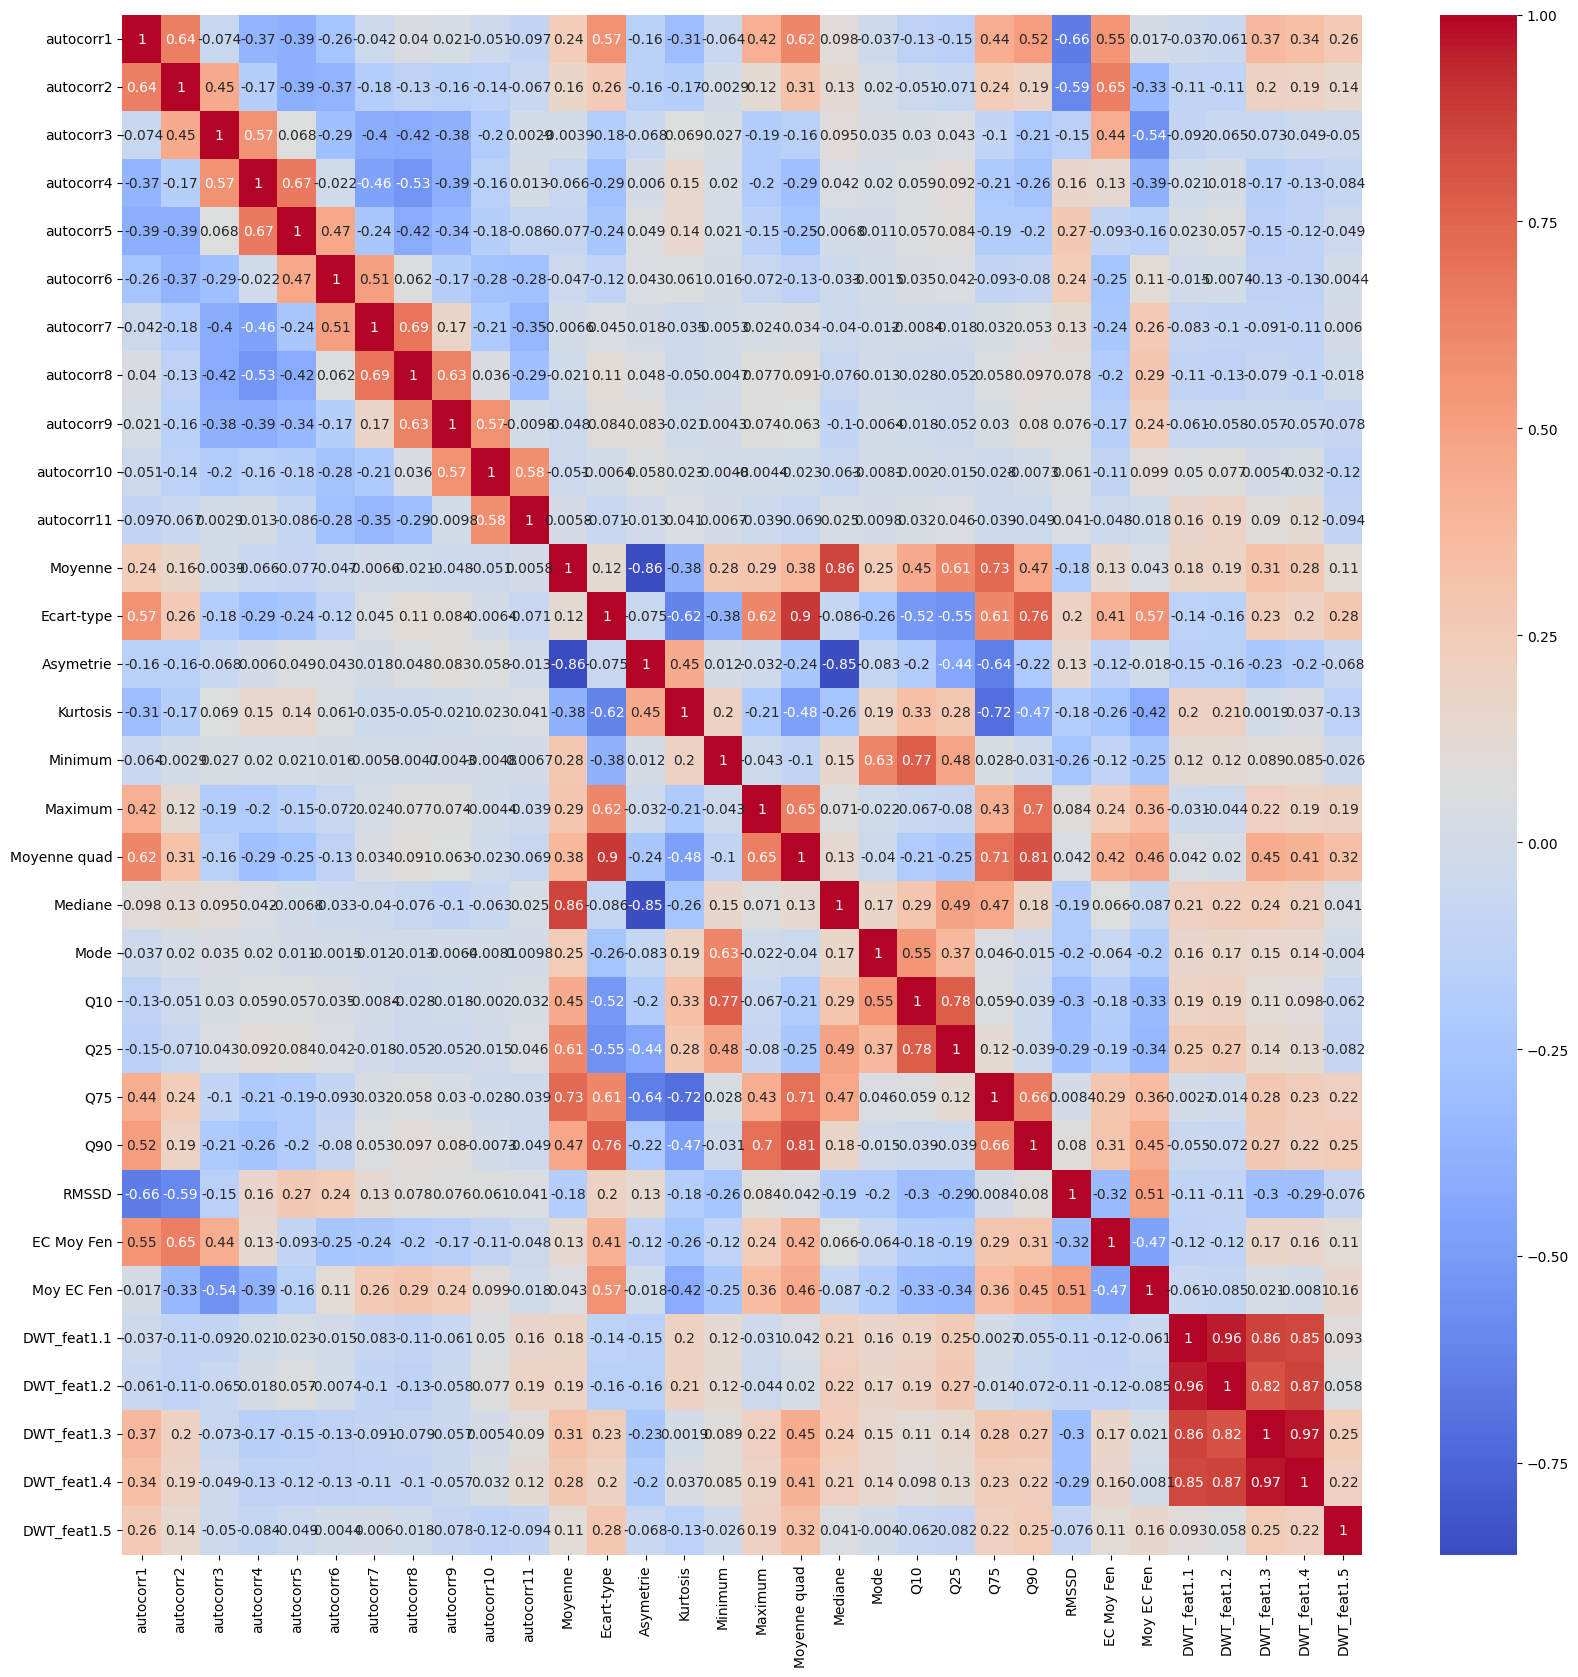

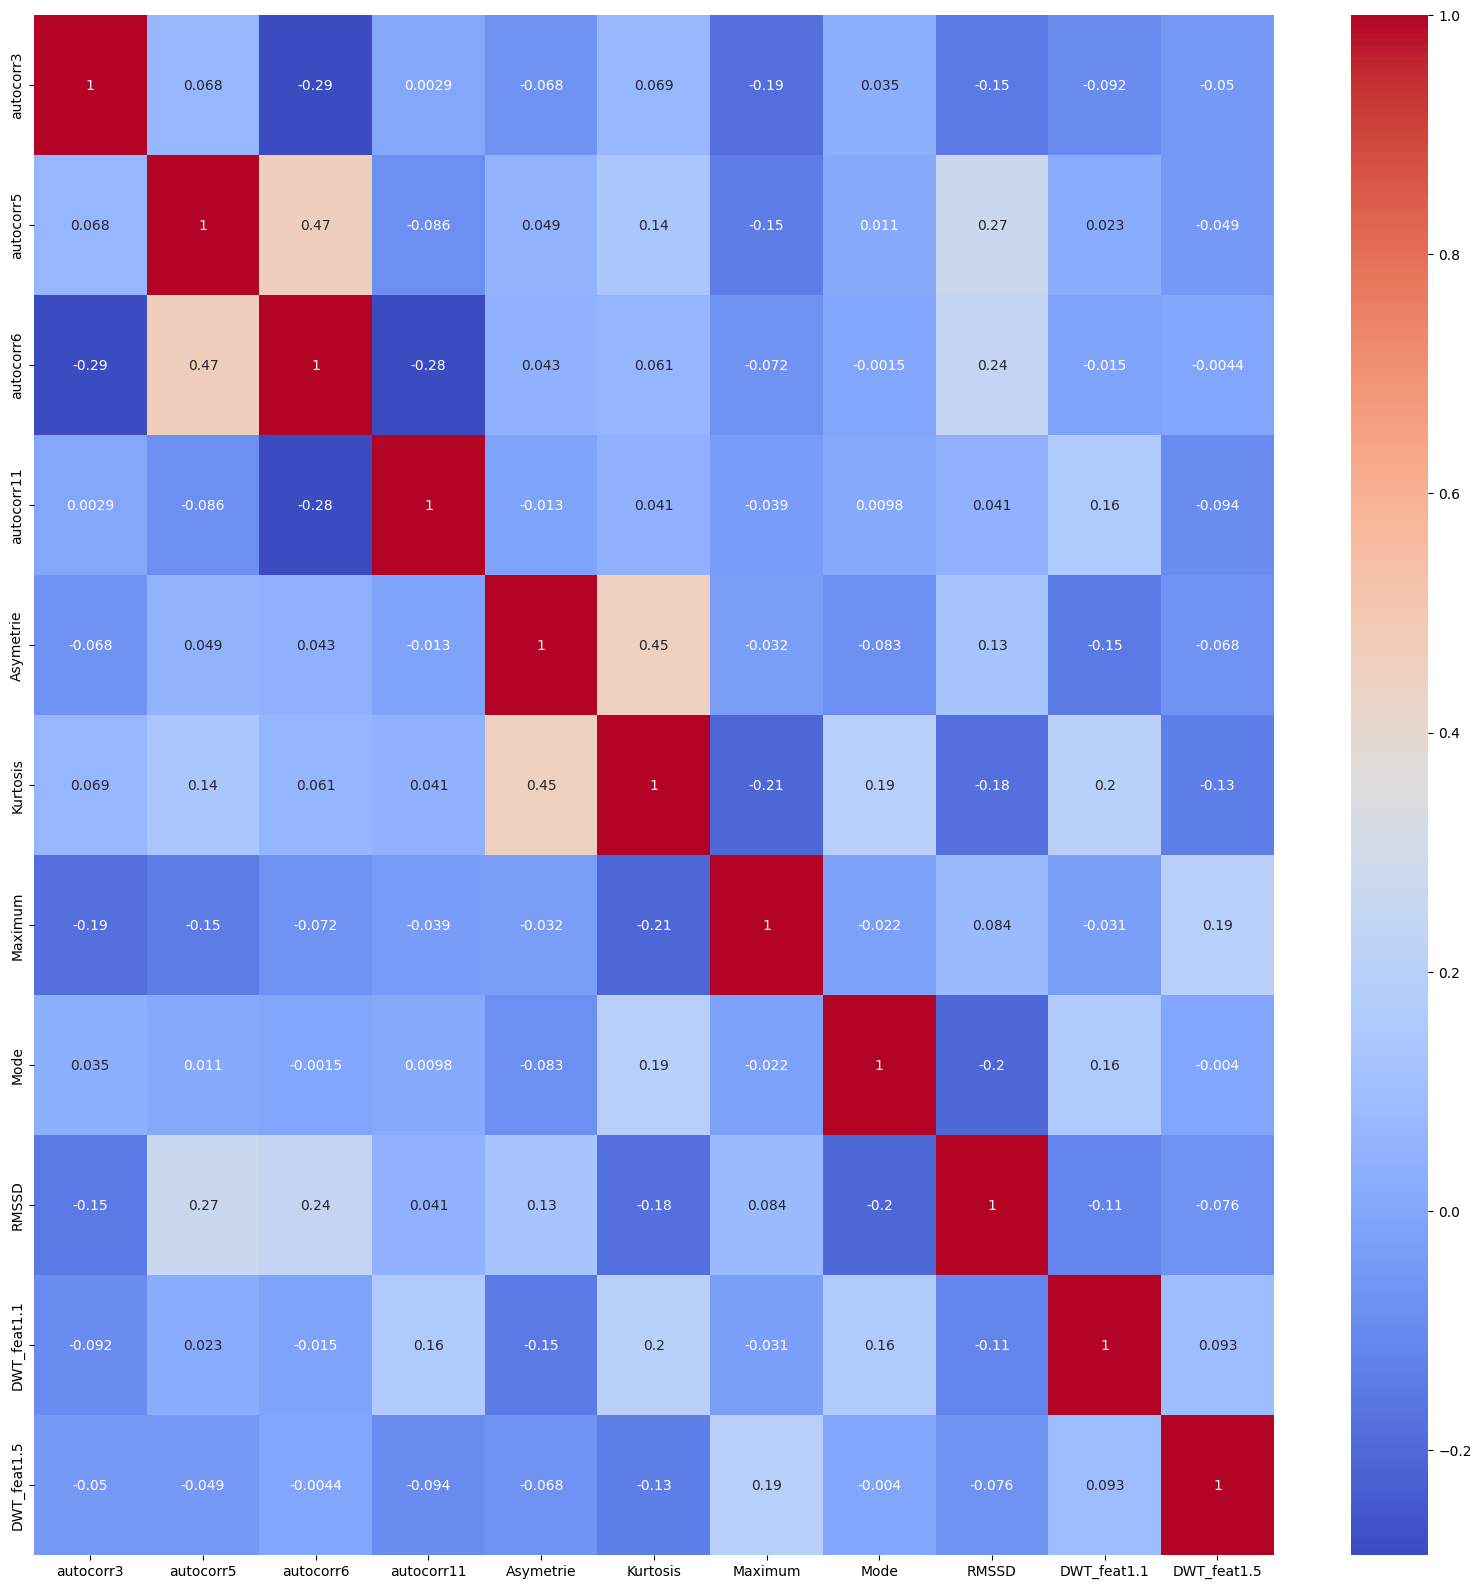

In [24]:
import seaborn as sns
plt.figure(figsize=(20,20))
sns.heatmap(df_concat.corr(),annot=True,cmap='coolwarm')
plt.figure(figsize=(20,20))
sns.heatmap(df_concat.loc[:,features_reduc_correl].corr(),annot=True,cmap='coolwarm')

In [35]:
# features = pd.concat((X_train,X_test))

# from itertools import combinations



# # 1. Calculer la matrice de corrélation
# corr_matrix = features.corr().abs()

# # 2. Extraire les indices de la matrice de corrélation
# indices = np.triu_indices_from(corr_matrix, k=1)
# corr_values = corr_matrix.values[indices]

# # 3. Trouver les combinaisons de colonnes avec la plus faible somme de corrélations
# def total_correlation(columns):
#     comb_corr = corr_matrix.loc[columns, columns]
#     return comb_corr.values[np.triu_indices_from(comb_corr, k=1)].sum()

# # Obtenir toutes les combinaisons possibles de 5 colonnes
# columns_combinations = list(combinations(features.columns, 5))

# # Calculer la somme des corrélations pour chaque combinaison
# combinations_corr = [(comb, total_correlation(comb)) for comb in columns_combinations]

# # Trouver la combinaison avec la plus faible somme de corrélations
# no_correl_feat = min(combinations_corr, key=lambda x: x[1])

# # Imprimer la meilleure combinaison d'attributs
# print("Les 5 attributs avec le moins de corrélation possible sont:", no_correl_feat[0])


KeyboardInterrupt: 

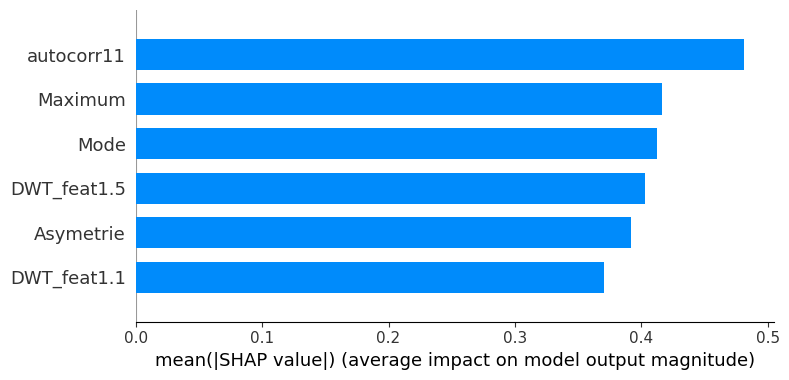

accuracy_score (no_fuzzy data): 0.5208988764044944
accuracy_score: 0.7346418195989514


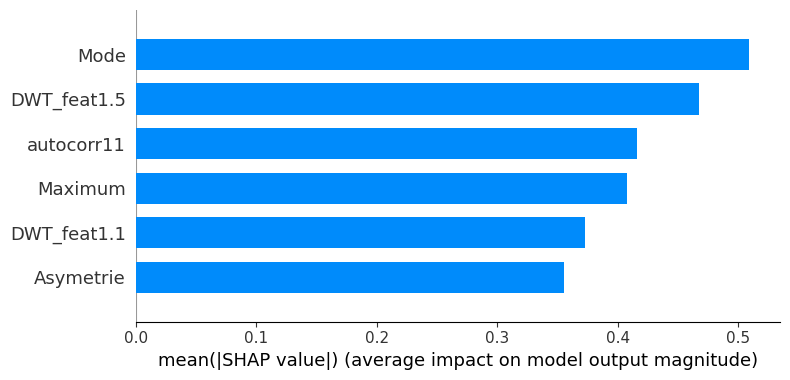

accuracy_score (no_fuzzy data): 0.5264419475655431
accuracy_score: 0.732161836604549


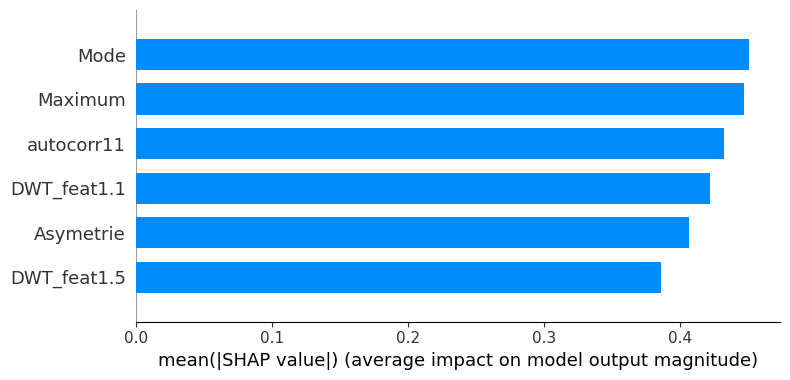

accuracy_score (no_fuzzy data): 0.5249438202247191
accuracy_score: 0.733933253029122


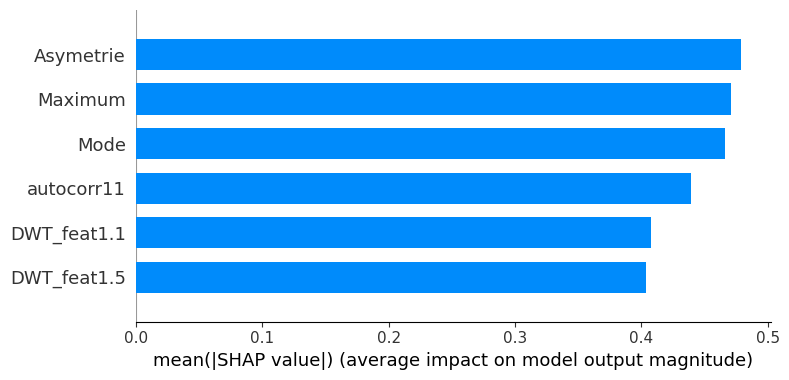

accuracy_score (no_fuzzy data): 0.5253932584269663
accuracy_score: 0.7314532700347197


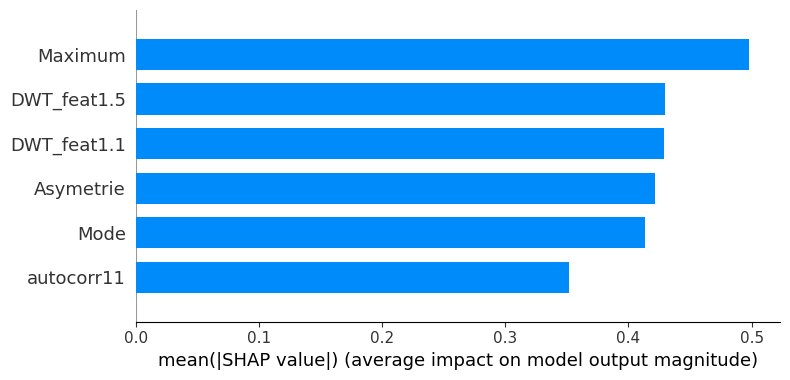

accuracy_score (no_fuzzy data): 0.5246441947565543
accuracy_score: 0.7323744065754978


In [28]:
# plt.figure(figsize=(20,20))
# for i in range(9):
#     plt.subplot(3,3,i+1)

#     explainer = shap.TreeExplainer(clf)
#     shap_values = explainer.shap_values(X_train.loc[:,no_correl_feat[0]])
#     shap.summary_plot(shap_values, X_train.loc[:,no_correl_feat[0]], plot_type='bar')
# plt.tight_layout()

# Créer une figure avec 9 subplots

# Entraîner 9 classifieurs différents et créer des summary_plots
for i in range(5):
    # Entraîner le classifieur
    clf = IsolationForest(random_state=i, n_estimators=100,max_features=1.0)
    clf.fit(X_train.loc[:,features_reduc_correl])
    
    # Utiliser SHAP pour expliquer le modèle
    explainer = shap.TreeExplainer(clf)
    shap_values= explainer.shap_values(X_train.loc[:,features_reduc_correl])
    
    shap.summary_plot(shap_values, X_train.loc[:,features_reduc_correl], plot_type='bar')
    pred = clf.predict(X_test.loc[:,features_reduc_correl])
    index_nofuzzy = df_test[(df_test["is_OK"]==-1) | (df_test["is_fuzzy"]==0)].index
    X_test_nofuzzy = X_test.iloc[index_nofuzzy,:]
    print("accuracy_score (no_fuzzy data):",accuracy_score(df_test.iloc[index_nofuzzy,:]["is_OK"].values,pred[index_nofuzzy]))
    print("accuracy_score:",accuracy_score(df_test["is_OK"].values,pred))

# print("MAX_FEATURE = 2")
# print("____________________________________________________________________________________________________")

# for i in range(9):
#     # Entraîner le classifieur
#     clf = IsolationForest(random_state=10+i, n_estimators=1000,max_features=2)
#     clf.fit(X_train.loc[:,no_correl_feat[0]])
    
#     # Utiliser SHAP pour expliquer le modèle
#     explainer = shap.TreeExplainer(clf)
#     shap_values= explainer.shap_values(X_train.loc[:,no_correl_feat[0]])
    
#     shap.summary_plot(shap_values, X_train.loc[:,no_correl_feat[0]], plot_type='bar')
#     pred = clf.predict(X_test.loc[:,no_correl_feat[0]])
#     index_nofuzzy = df_test[(df_test["is_OK"]==-1) | (df_test["is_fuzzy"]==0)].index
#     X_test_nofuzzy = X_test.iloc[index_nofuzzy,:]
#     print("accuracy_score (no_fuzzy data):",accuracy_score(df_test.iloc[index_nofuzzy,:]["is_OK"].values,pred[index_nofuzzy]))
#     print("accuracy_score:",accuracy_score(df_test["is_OK"].values,pred))

In [19]:


df_train, df_test = train_test_split_cowseries(dataframes_serie)
zmean, MEAN_DWT_1, MEAN_DWT_2, ZMEAN_DWT_1, ZMEAN_DWT_2 = get_means_DWT(df_train,waveletname,level_approximation)

X_train = get_att(df_train)
X_test = get_att(df_test)


X_concat = pd.concat((X_train,X_test))
features_reduc_correl = remove_highly_correlated_features(X_concat, 0.8).columns
# clf = IsolationForest(random_state=0, n_estimators=100, max_features=1.0)
# clf.fit(X_train.loc[:,features_reduc_correl])

Decomposition wavelet db2
level max of approximation : 3


In [50]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(random_state=0, n_estimators=100, max_features=1.0)
clf.fit(X_train.loc[:,features_reduc_correl])

IsolationForest(n_estimators=10, random_state=1)

In [37]:
pred = clf.predict(X_test.loc[:,features_reduc_correl])
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

index_nofuzzy = df_test[(df_test["is_OK"]==-1) | (df_test["is_fuzzy"]==0)].index
X_test_nofuzzy = X_test.iloc[index_nofuzzy,:]
print("accuracy_score (no_fuzzy data):",accuracy_score(df_test.iloc[index_nofuzzy,:]["is_OK"].values,pred[index_nofuzzy]))
print("accuracy_score:",accuracy_score(df_test["is_OK"].values,pred))

accuracy_score (no_fuzzy data): 0.5482295482295483
accuracy_score: 0.7602573266619014


In [24]:
ACC = []
for i in range(10):
    clf = IsolationForest(random_state=i, n_estimators=100, max_features=1.0)
    clf.fit(X_train.loc[:,features_reduc_correl])

    pred = clf.predict(X_test.loc[:,features_reduc_correl])


    index_nofuzzy = df_test[(df_test["is_OK"]==-1) | (df_test["is_fuzzy"]==0)].index
    X_test_nofuzzy = X_test.iloc[index_nofuzzy,:]
    print("accuracy_score (no_fuzzy data):",accuracy_score(df_test.iloc[index_nofuzzy,:]["is_OK"].values,pred[index_nofuzzy]))
    print("accuracy_score:",accuracy_score(df_test["is_OK"].values,pred))
    ACC.append(accuracy_score(df_test.iloc[index_nofuzzy,:]["is_OK"].values,pred[index_nofuzzy]))

accuracy_score (no_fuzzy data): 0.5418859978944203
accuracy_score: 0.7503371903173138
accuracy_score (no_fuzzy data): 0.5381260339900737
accuracy_score: 0.7496983034002982
accuracy_score (no_fuzzy data): 0.5390284253271168
accuracy_score: 0.7473557180379072
accuracy_score (no_fuzzy data): 0.5477515415852008
accuracy_score: 0.750195215446866
accuracy_score (no_fuzzy data): 0.5417355993382463
accuracy_score: 0.752040888762689
accuracy_score (no_fuzzy data): 0.544292374793202
accuracy_score: 0.752040888762689
accuracy_score (no_fuzzy data): 0.545345164686419
accuracy_score: 0.7533896500319444
accuracy_score (no_fuzzy data): 0.5450443675740713
accuracy_score: 0.7531057002910485
accuracy_score (no_fuzzy data): 0.5426379906752895
accuracy_score: 0.7474976929083552
accuracy_score (no_fuzzy data): 0.5396300195518123
accuracy_score: 0.7550223610420955


In [23]:
np.array(ACC)

array([0.53963002])

In [25]:
ACC_mean = np.array(ACC).mean()
ACC_std = np.array(ACC).std()

print(ACC_mean)
print(ACC_std)

0.5425477515415853
0.0029281019157498434


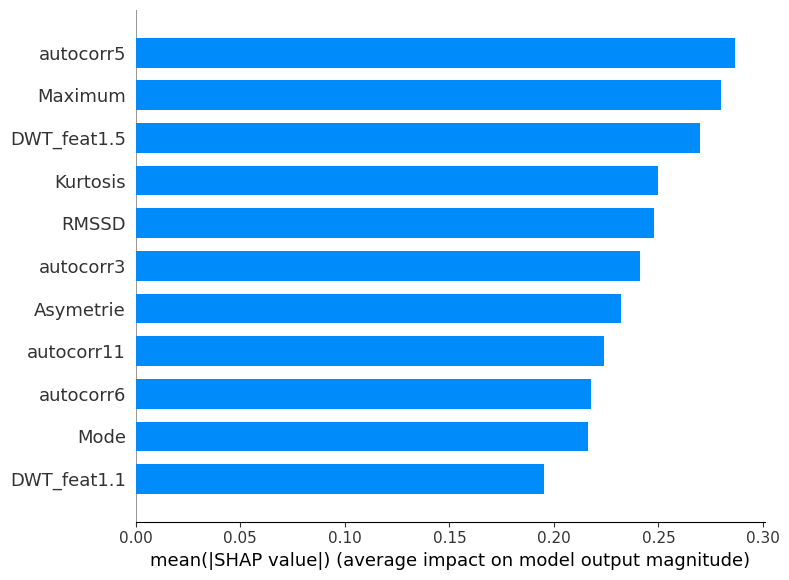

In [30]:
shap.summary_plot(shap_values, X_train.loc[:,features_reduc_correl], plot_type='bar')
#pd.DataFrame(np.mean(np.abs(shap_values),axis=0),columns=features_reduc_correl)

In [21]:
import csv
import shap
from sklearn.ensemble import IsolationForest
nb_IF_exec = 50

# Création du fichier CSV
with open('DDC_100arbres.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    # Écriture de l'en-tête
    writer.writerow(['classifier_name', 'dataset_name', 'accuracy'])
    # Écriture des lignes de données
    k=0
    for j in range(nb_IF_exec):
        clf = IsolationForest(random_state=j, n_estimators=100)
        clf.fit(X_train.loc[:,features_reduc_correl])
        explainer = shap.TreeExplainer(clf)
        shap_values = explainer.shap_values(X_train.loc[:,features_reduc_correl])
        mean_shap_values = np.mean(np.abs(shap_values),axis=0)
        for i in range(len(features_reduc_correl)):
            writer.writerow([features_reduc_correl[i], f'exec_{j}', mean_shap_values[i]])

# with open('DDC_200arbres_02corr.csv', mode='w', newline='') as file:
#     writer = csv.writer(file)
#     # Écriture de l'en-tête
#     writer.writerow(['classifier_name', 'dataset_name', 'accuracy'])
#     # Écriture des lignes de données
#     k=0
#     for j in range(nb_IF_exec):
#         clf = IsolationForest(random_state=j, n_estimators=200)
#         clf.fit(X_train.loc[:,features_reduc_correl])
#         explainer = shap.TreeExplainer(clf)
#         shap_values = explainer.shap_values(X_train.loc[:,features_reduc_correl])
#         mean_shap_values = np.mean(np.abs(shap_values),axis=0)
#         for i in range(len(features_reduc_correl)):
#             writer.writerow([features_reduc_correl[i], f'exec_{j}', mean_shap_values[i]])

# with open('DDC_100arbres_2MF_02corr.csv', mode='w', newline='') as file:
#     writer = csv.writer(file)
#     # Écriture de l'en-tête
#     writer.writerow(['classifier_name', 'dataset_name', 'accuracy'])
#     # Écriture des lignes de données
#     k=0
#     for j in range(nb_IF_exec):
#         clf = IsolationForest(random_state=j, n_estimators=100,max_features=2)
#         clf.fit(X_train.loc[:,features_reduc_correl])
#         explainer = shap.TreeExplainer(clf)
#         shap_values = explainer.shap_values(X_train.loc[:,features_reduc_correl])
#         mean_shap_values = np.mean(np.abs(shap_values),axis=0)
#         for i in range(len(features_reduc_correl)):
#             writer.writerow([features_reduc_correl[i], f'exec_{j}', mean_shap_values[i]])

# with open('DDC_200arbres_2MF_02corr.csv', mode='w', newline='') as file:
#     writer = csv.writer(file)
#     # Écriture de l'en-tête
#     writer.writerow(['classifier_name', 'dataset_name', 'accuracy'])
#     # Écriture des lignes de données
#     k=0
#     for j in range(nb_IF_exec):
#         clf = IsolationForest(random_state=j, n_estimators=200,max_features=2)
#         clf.fit(X_train.loc[:,features_reduc_correl])
#         explainer = shap.TreeExplainer(clf)
#         shap_values = explainer.shap_values(X_train.loc[:,features_reduc_correl])
#         mean_shap_values = np.mean(np.abs(shap_values),axis=0)
#         for i in range(len(features_reduc_correl)):
#             writer.writerow([features_reduc_correl[i], f'exec_{j}', mean_shap_values[i]])

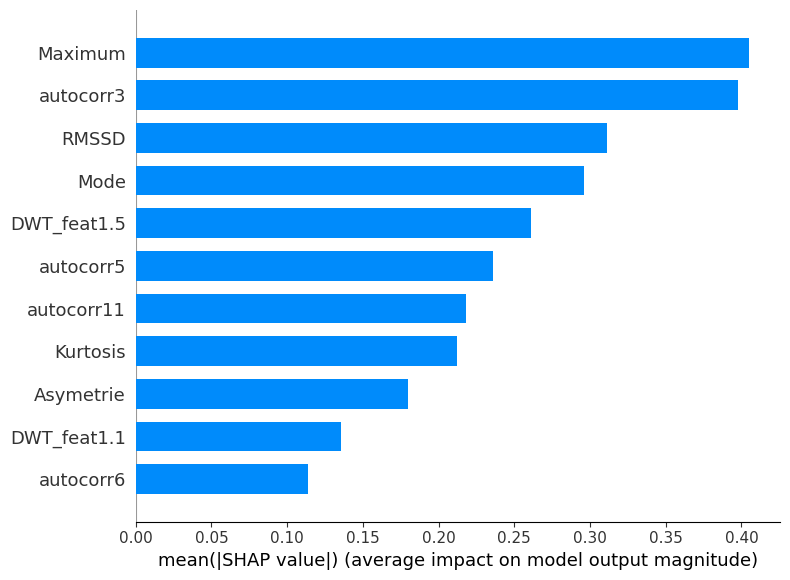

In [26]:
import shap

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train.loc[:,features_reduc_correl])
shap.summary_plot(shap_values, X_train.loc[:,features_reduc_correl], plot_type='bar')

In [51]:
test_tmp = df_test.copy()    

# Créer une colonne datetime à partir de date et heure
test_tmp['datetime'] = pd.to_datetime(test_tmp['date'] + ' ' + test_tmp['hour'].astype(str) + ':00:00')

    # Trier par datetime
    #datacow = datacow.sort_values('datetime').reset_index(drop=True)
test_tmp = test_tmp.reset_index(drop=True)
    # Décaler les valeurs de datetime et calculer la différence en heures
test_tmp['prev_datetime'] = test_tmp['datetime'].shift(1)
test_tmp['diff_hours'] = (test_tmp['datetime'] - test_tmp['prev_datetime']).dt.total_seconds() / 3600
break_points = test_tmp[test_tmp['diff_hours'] != 1].index

In [52]:
def count_negative_series(arr):
    series_lengths = []
    current_count = 0
    
    for num in arr:
        if num == -1:
            current_count += 1
        else:
            if current_count > 0:
                series_lengths.append(current_count)
                current_count = 0
    
    # Ajouter la dernière série si le tableau se termine par une série de -1
    if current_count > 0:
        series_lengths.append(current_count)
    
    return series_lengths


def score_consec(serie):
    S = count_negative_series(serie)
    n = sum(S)
    score=0
    for i in range(len(S)):
        score+=S[i]**2
    if n!=0:
        score = score / n**2
    return score
def len_an(serie):
    serie = np.array(serie)
    an_loc = np.where(serie==-1)[0]
    if len(an_loc)==0:
        return 0
    
    first_an = an_loc[0]
    last_an = an_loc[-1]
    length = last_an - first_an+1
    return length

def score2(serie):
    num = np.sum(serie==-1)
    den = len_an(serie)
    return num/den


In [53]:
def score_pred(true,pred):

    # Trouver les indices où A est égal à -1
    indices_true_an = np.where(true == -1)[0]
    if indices_true_an.shape[0]==0:
        return 1

    # Vérifier si B aux mêmes indices est également égal à -1
    matching_indices = indices_true_an[pred[indices_true_an] == -1]

    # Afficher les indices correspondants
    return matching_indices.shape[0]/indices_true_an.shape[0]



In [54]:
def score_prec(true,pred):
    indices_pred_an = np.where(pred == -1)[0]
    if indices_pred_an.shape[0]==0:
        return 1
    matching_indices = indices_pred_an[true[indices_pred_an] == -1]
    return matching_indices.shape[0]/indices_pred_an.shape[0]

In [61]:
df_test[break_points[istart+i]:break_points[istart+i+1]]['cow_serie'].unique()

array(['c6621,s4'], dtype=object)

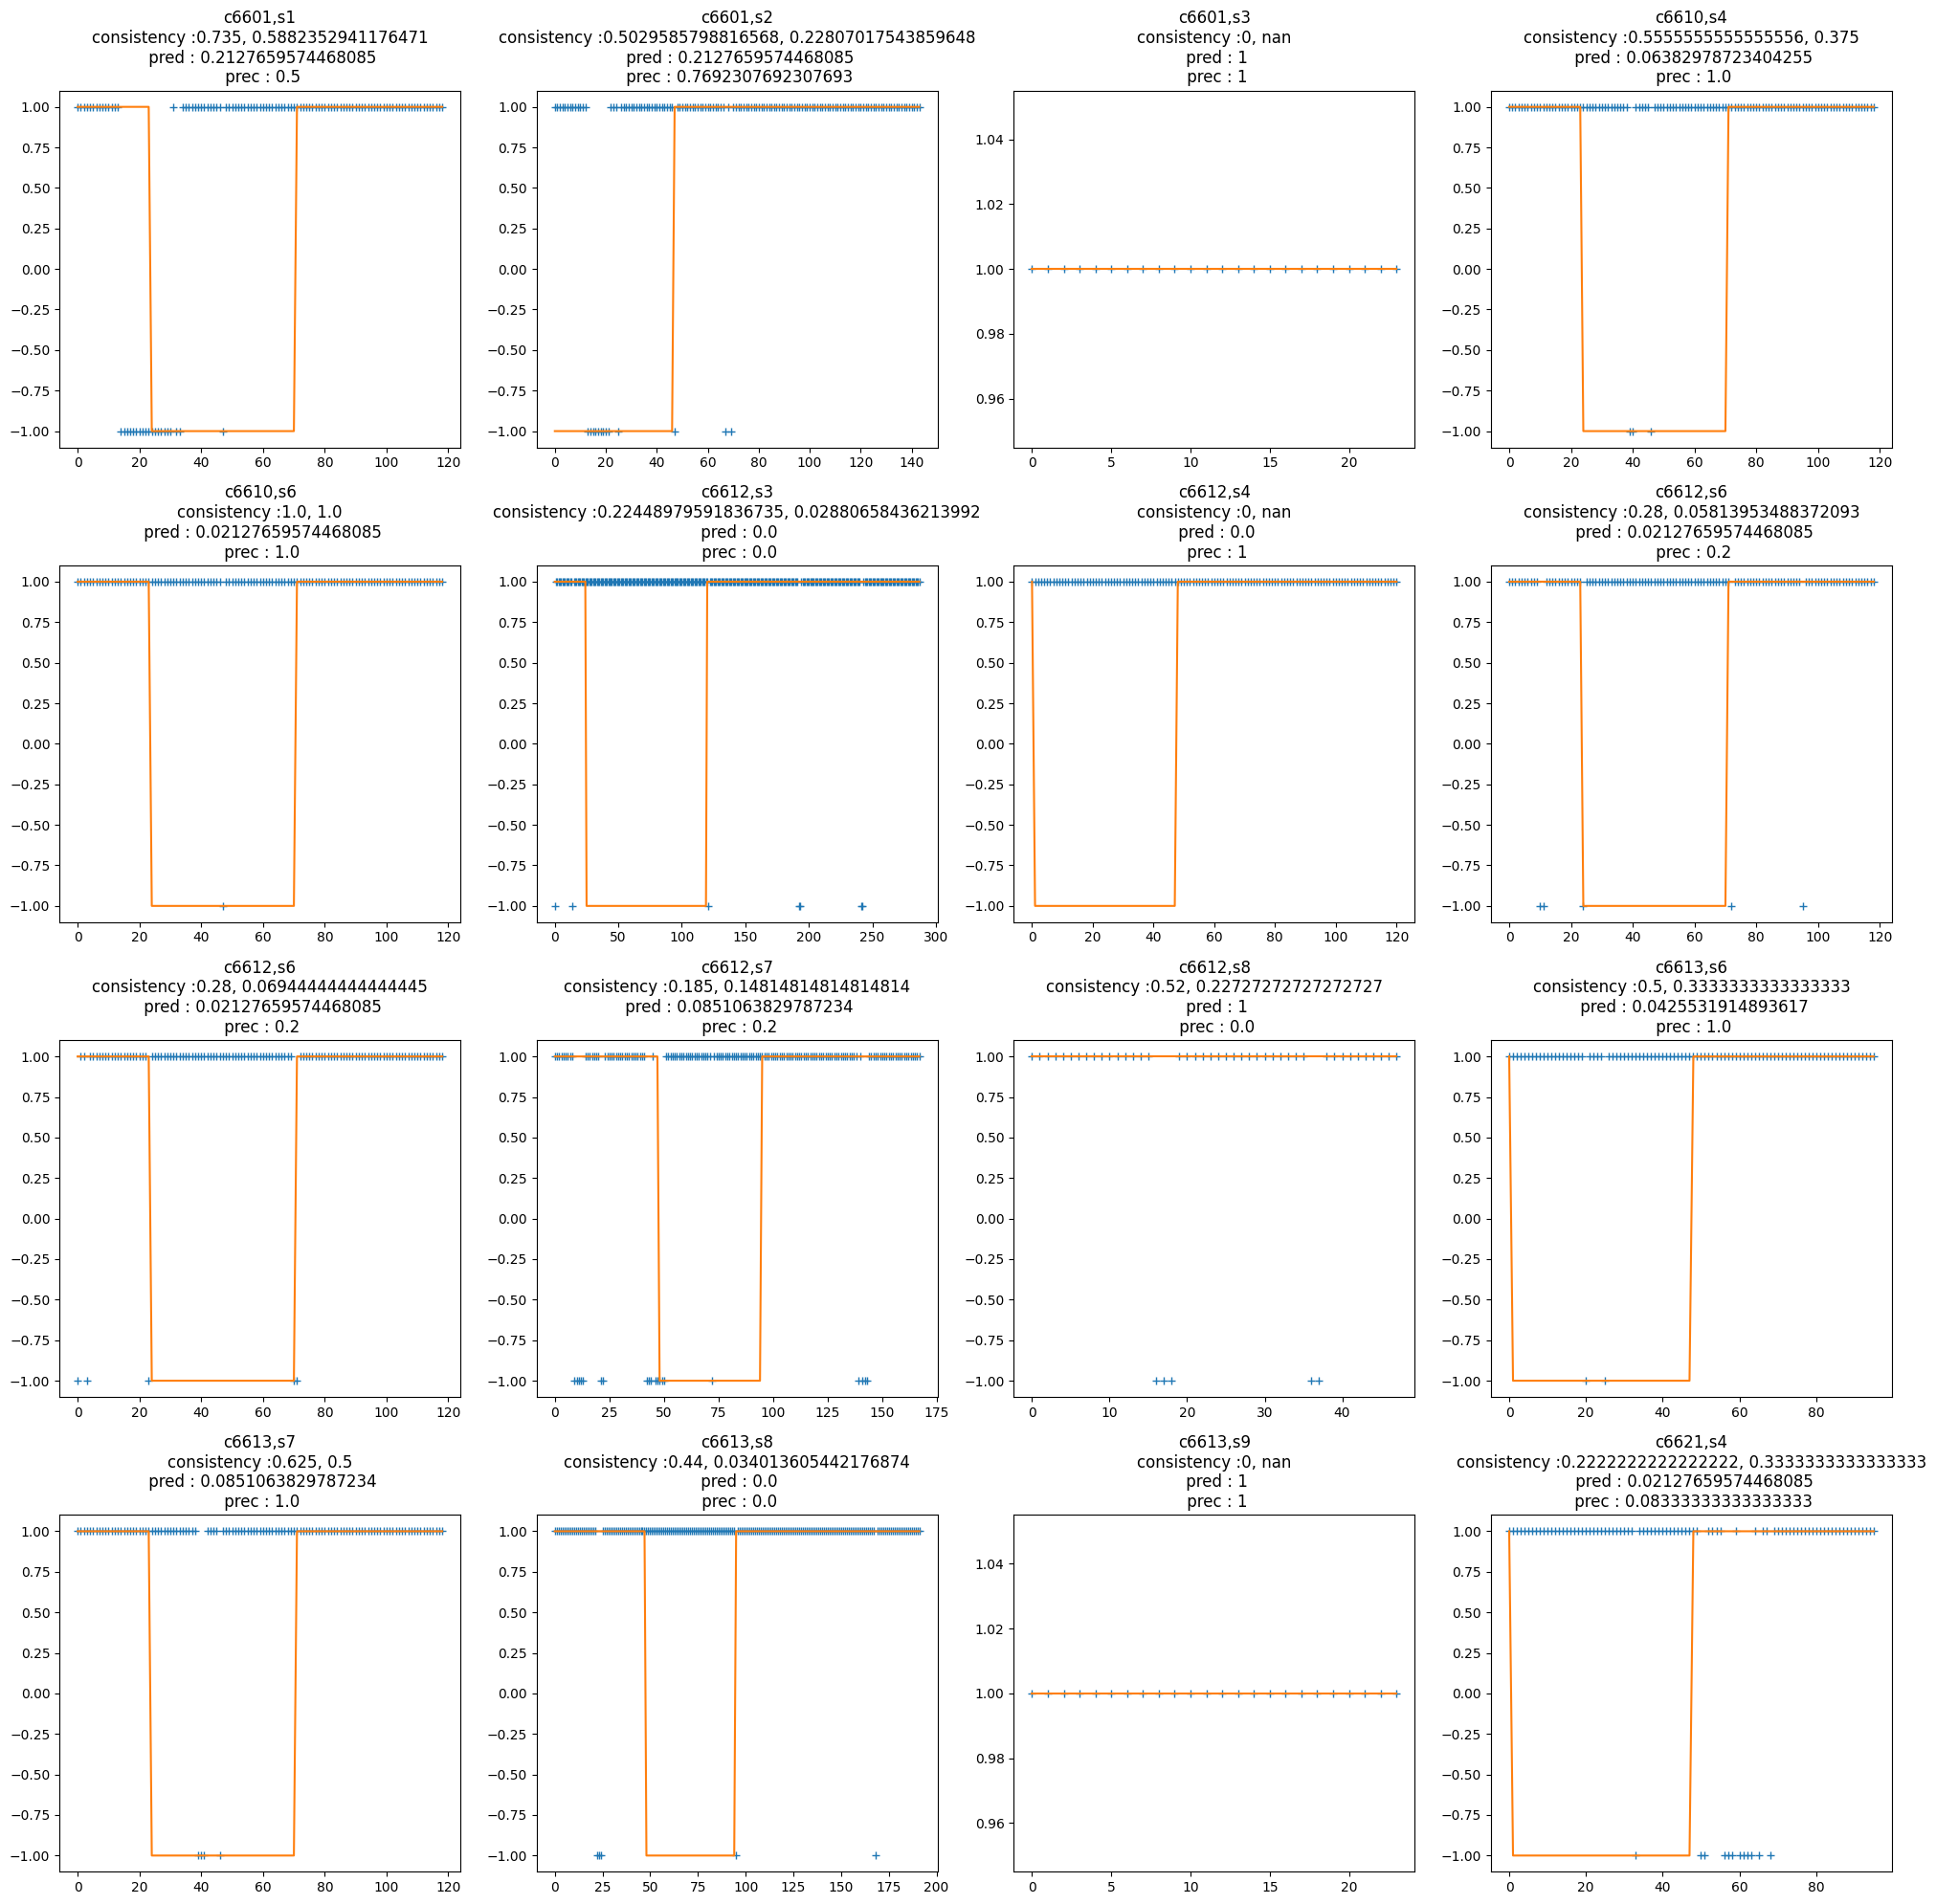

In [62]:
plt.figure(figsize=(20,20))
istart=0
for i in range(16):
    plt.subplot(4,4,i+1)
    serie = pred[break_points[istart+i]:break_points[istart+i+1]]
    true_serie = df_test[break_points[istart+i]:break_points[istart+i+1]]["is_OK"].values
    if df_test[break_points[istart+i]:break_points[istart+i+1]]['cow_serie'].unique().shape[0]==1:
        cowseriename = df_test[break_points[istart+i]:break_points[istart+i+1]]['cow_serie'].unique()[0]
    else:
        cowseriename = "NULL"
        print("ALERTTTT")
    plt.title(cowseriename + '\nconsistency :' + str(score_consec(serie))  + ', ' + str(score2(serie)) + '\n pred : ' + str(score_pred(true_serie,serie)) + '\n prec : ' + str(score_prec(true_serie,serie)))
    plt.plot(pred[break_points[istart+i]:break_points[istart+i+1]],'+')
    plt.plot(df_test[break_points[istart+i]:break_points[istart+i+1]]["is_OK"].values,'-')
plt.tight_layout()

In [40]:
def score_detection(pred_serie,true_serie):
    return 0
    

In [41]:
S = count_negative_series(pred[break_points[1]:break_points[2]])
n = sum(S)
score=0
for i in range(len(S)):
    score+=S[i]**2
score = score / n**2
score

1.0

accuracy_score (no_fuzzy data): 0.5208988764044944
accuracy_score: 0.7346418195989514


In [43]:
sum(df_test.iloc[index_nofuzzy,:]["is_OK"].values==1)

3424

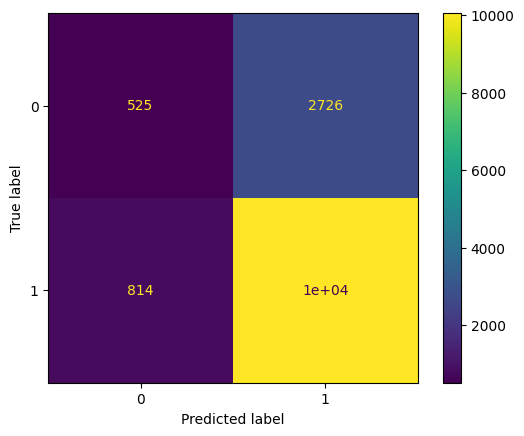

In [44]:
cm = confusion_matrix(df_test["is_OK"].values, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

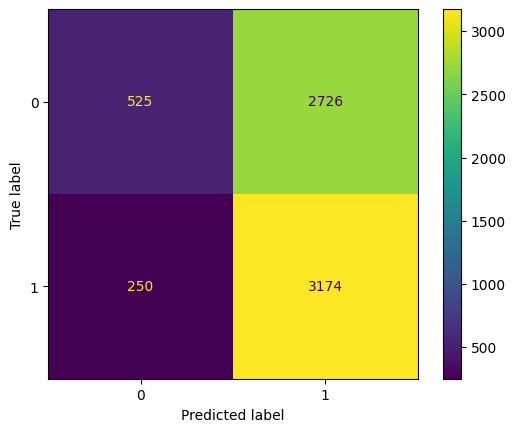

In [45]:
cm = confusion_matrix(df_test.iloc[index_nofuzzy,:]["is_OK"].values, pred[index_nofuzzy])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

<Axes: >

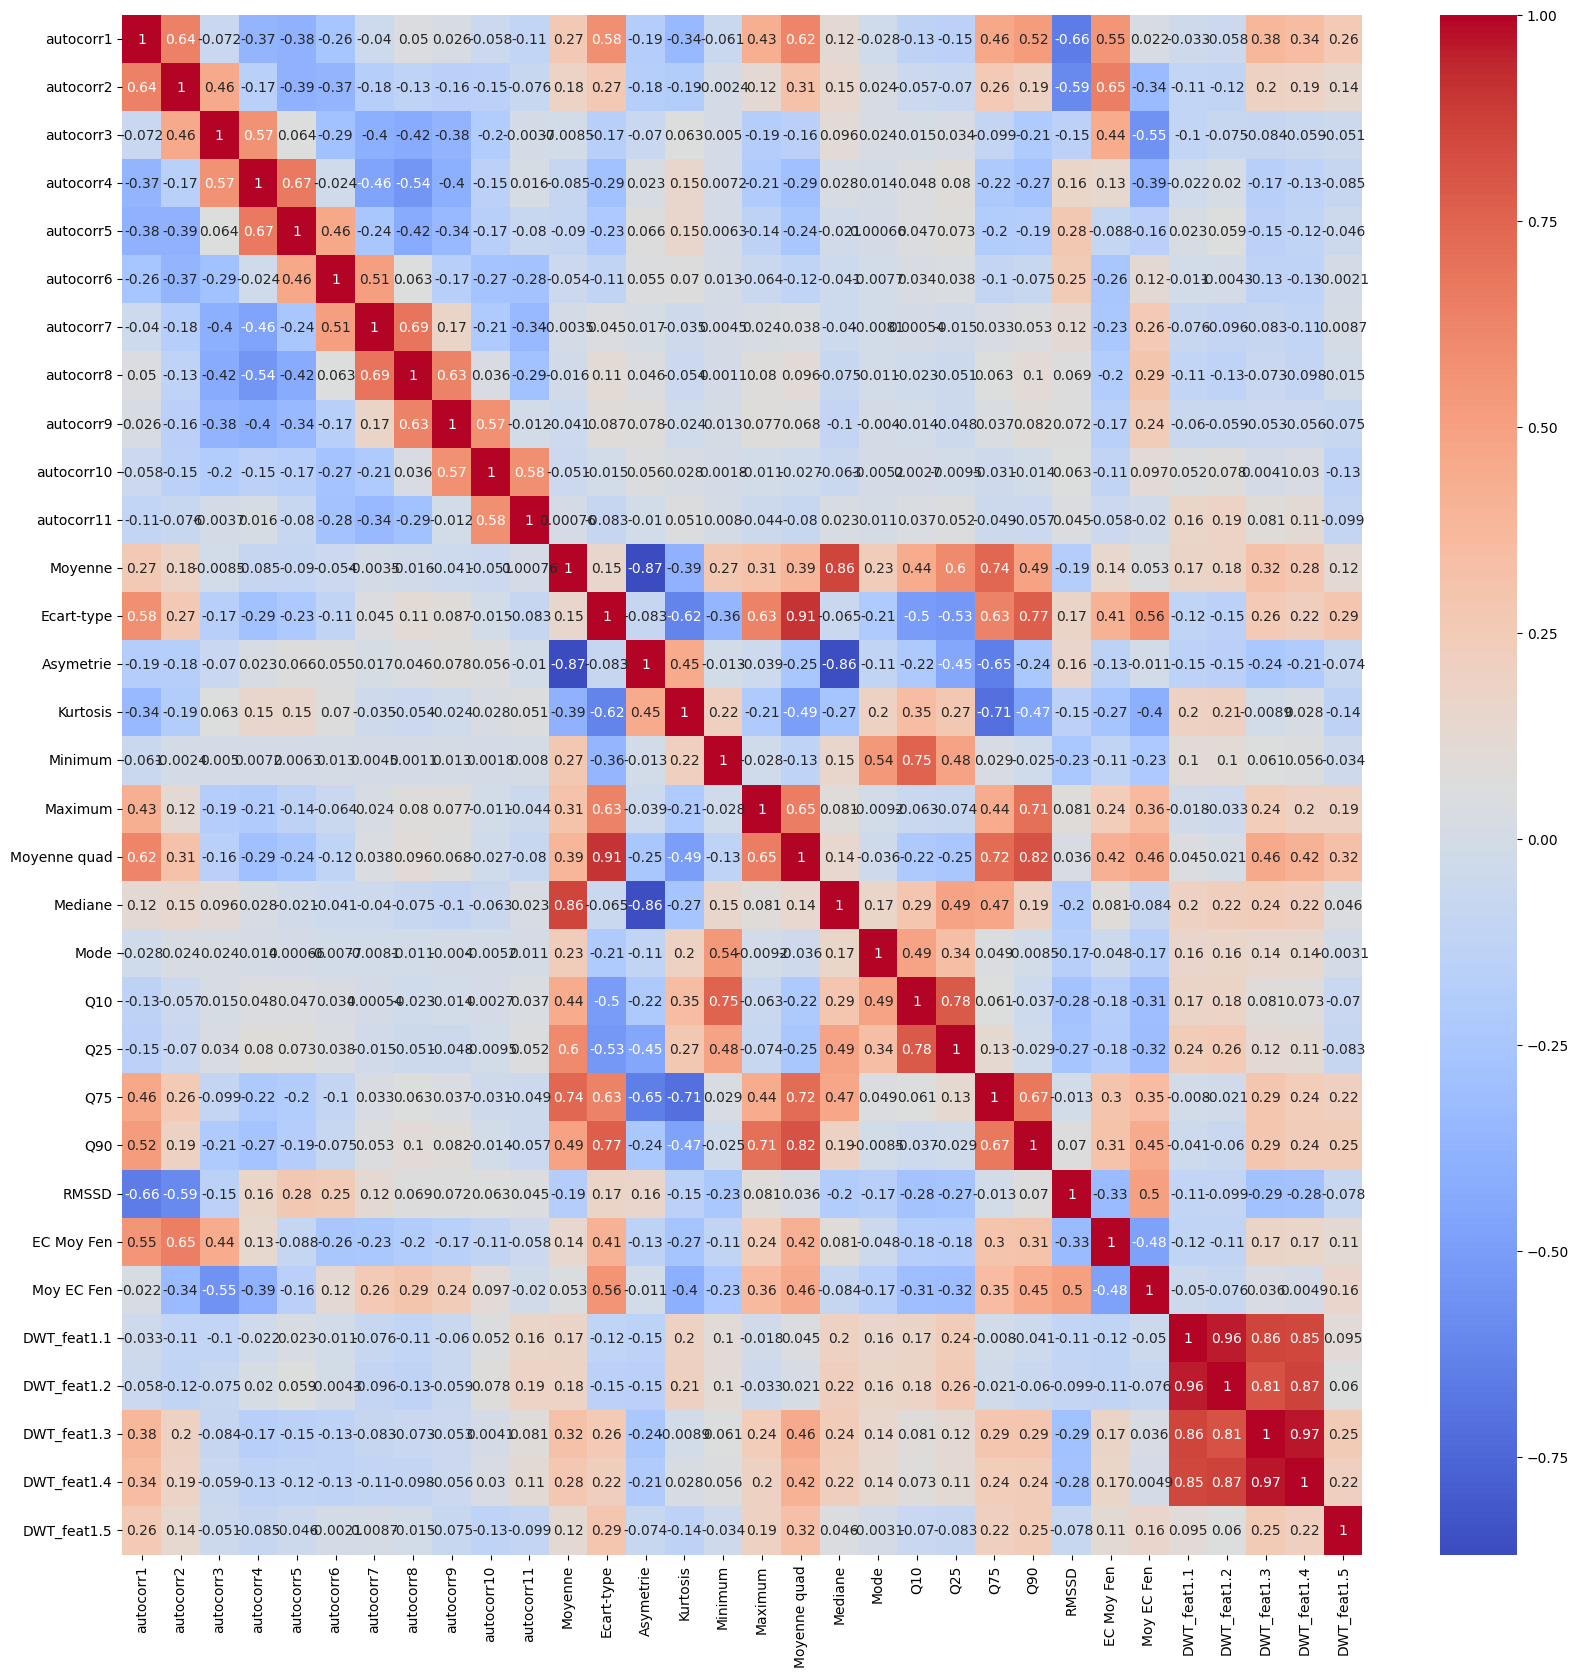

In [46]:
import seaborn as sns
plt.figure(figsize=(20,20))
sns.heatmap(pd.DataFrame(X_train).corr(),annot=True,cmap='coolwarm')

In [47]:
for i in range(119):
    print(pred[i], '|', myserie1.iloc[i]["is_OK"])
print("Serie 2")
for i in range(119,287):
    print(pred[i], '|', myserie2.iloc[i-119]["is_OK"])

NameError: name 'myserie1' is not defined

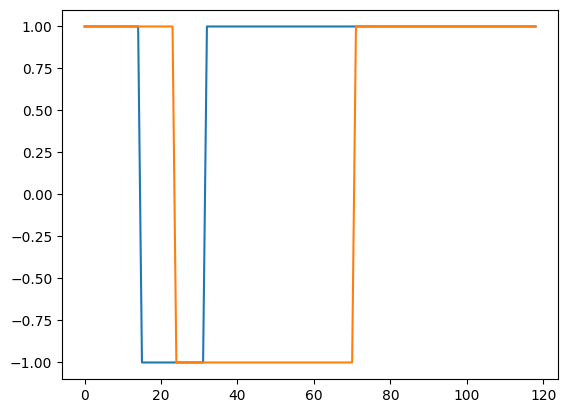

In [ ]:
import matplotlib.pyplot as plt
plt.plot(pred[:119],'-')
plt.plot(myserie1["is_OK"].values,'-')

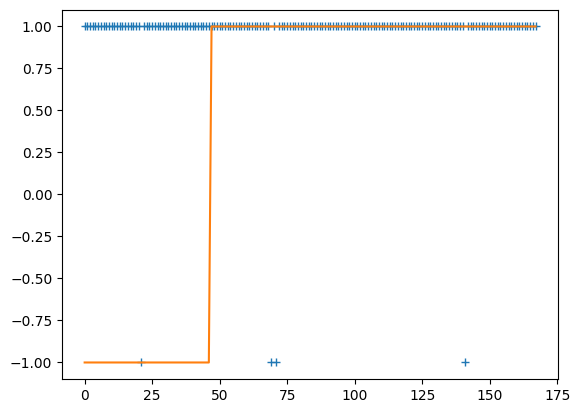

In [ ]:
plt.plot(pred[119:287],'+')
plt.plot(myserie2["is_OK"].values,'-')

In [ ]:
#import datasets
data_dict = {}

for key in datasets.keys():
    dataset_dict = {}
    
    rawdata = pd.read_csv(datasets[key])
    data = remove_incomplete_day(rawdata)
    dataset_dict["start_date"] = np.sort(data['date'].unique())[0]
    dataset_dict["end_date"] = np.sort(data['date'].unique())[-1]
    dataset_dict["cownumber"] = data['cow'].unique().size
    dataset_dict["datasize"] = data.shape[0]

    s=rawdata[['oestrus','calving','lameness','mastitis','LPS','acidosis','other_disease', 'accidents','disturbance','mixing','management_changes','OK']].sum().astype(int)//24
    t = rawdata[['oestrus','calving','lameness','mastitis','LPS','acidosis','other_disease', 'accidents']].sum().astype(int)//24
    dataset_dict["anomaly_rate"] = t.sum()/s.sum()*100

    dataset_dict["data"] = []

    cows = rawdata['cow'].unique()
    for cow in cows:
        datacow_dict = {}
        datacow = data[data['cow']==cow]
        datacow_dict["cowname"]=str(cow)
        datacow_dict["start_date"]=np.sort(datacow['date'].unique())[0]
        datacow_dict["end_date"]=np.sort(datacow['date'].unique())[-1]
        datacow_dict['data']=[]

        cons_dates = get_consecutive_dates(datacow['date'].unique())
     
        for serie in cons_dates:
            datacowserie_dict = {}
            datacowserie = datacow[datacow['date'].isin(serie)]
        
            datacowserie_dict["start_date"]=np.sort(datacowserie['date'].unique())[0]
            datacowserie_dict["end_date"]=np.sort(datacowserie['date'].unique())[-1]
            datacowserie_dict["activity_level"]=datacowserie["ACTIVITY_LEVEL"].values.tolist()

            datacow_dict['data'].append(datacowserie_dict)

        dataset_dict['data'].append(datacow_dict)
        
    data_dict[key]=dataset_dict
    
#   for cow in cows:
#       datacow = rawdata[rawdata['cow']==cow]

In [ ]:
def get_consecutive_dates(array_tab):
    """From an array of dates, return an array of array of consecutives dates"""
    if len(array_tab) == 0:
        return []

    array_tab_sorted = np.sort(array_tab)
    set_dates = []
    current_set_dates = [array_tab_sorted[0]]

    for i in range(1, len(array_tab_sorted)):
        date_actuelle = np.datetime64(array_tab_sorted[i])
        date_precedente = np.datetime64(array_tab_sorted[i - 1])

        if (date_actuelle - date_precedente).astype(int) == 1:
            current_set_dates.append(array_tab_sorted[i])
        else:
            set_dates.append(current_set_dates)
            current_set_dates = [array_tab_sorted[i]]

    set_dates.append(current_set_dates)

    return set_dates

# for cow in cows:
#     cons_dates = get_consecutive_dates(datacow['date'].unique())
#     for serie in cons_dates:
#         datacowserie = datacow[datacow['date'].isin(serie)]
#         data.loc[datacowserie.index[0]:datacowserie.index[-1],"ACTIVITY_LEVEL"] = data.loc[datacowserie.index[0]:datacowserie.index[-1],"ACTIVITY_LEVEL"].shift(shiftdirection)

In [ ]:
cons_dates = get_consecutive_dates(datacow['date'].unique())
cons_dates

[['2018-11-10',
  '2018-11-11',
  '2018-11-12',
  '2018-11-13',
  '2018-11-14',
  '2018-11-15',
  '2018-11-16',
  '2018-11-17',
  '2018-11-18',
  '2018-11-19',
  '2018-11-20',
  '2018-11-21',
  '2018-11-22',
  '2018-11-23',
  '2018-11-24',
  '2018-11-25',
  '2018-11-26',
  '2018-11-27',
  '2018-11-28',
  '2018-11-29',
  '2018-11-30',
  '2018-12-01',
  '2018-12-02',
  '2018-12-03',
  '2018-12-04',
  '2018-12-05',
  '2018-12-06',
  '2018-12-07',
  '2018-12-08',
  '2018-12-09',
  '2018-12-10',
  '2018-12-11',
  '2018-12-12',
  '2018-12-13',
  '2018-12-14',
  '2018-12-15',
  '2018-12-16',
  '2018-12-17',
  '2018-12-18',
  '2018-12-19',
  '2018-12-20',
  '2018-12-21',
  '2018-12-22',
  '2018-12-23',
  '2018-12-24',
  '2018-12-25',
  '2018-12-26',
  '2018-12-27',
  '2018-12-28',
  '2018-12-29',
  '2018-12-30',
  '2018-12-31',
  '2019-01-01',
  '2019-01-02',
  '2019-01-03',
  '2019-01-04',
  '2019-01-05',
  '2019-01-06',
  '2019-01-07',
  '2019-01-08',
  '2019-01-09',
  '2019-01-10',
  '2019-

In [ ]:
datacowserie_dict["activity_level"].tolist()

[1401.10332,
 -100.39673,
 -816.29979,
 -825.49248,
 -824.65866,
 -827.99862,
 -761.82446,
 559.69343,
 746.23339,
 193.06948,
 562.48606,
 -816.31734,
 -827.99862,
 278.86129,
 1054.11018,
 90.04903,
 1120.12522,
 441.73595,
 -827.99862,
 -215.97058,
 -71.56333,
 -827.99862,
 -819.63585,
 430.1146,
 -56.1023,
 -825.48858,
 -787.85319,
 -827.16363,
 -827.99862,
 423.31742,
 91.15611,
 445.3038,
 1019.83633,
 1376.19792,
 1393.46712,
 -107.1442,
 -796.50729,
 -827.99862,
 979.43441,
 1391.16898,
 803.34486,
 512.09494,
 -188.92076,
 -821.10498,
 -825.4917,
 -823.6158,
 -824.03037,
 -819.43149,
 -637.00444,
 -827.99862,
 -814.209,
 -827.99862,
 -785.80374,
 -815.04243,
 -587.53515,
 255.66097,
 141.23536,
 1443.60084,
 1432.50872,
 1158.09718,
 -793.3362,
 -827.99862,
 -827.99862,
 -827.99862,
 988.1877,
 1396.81098,
 292.34398,
 -827.99862,
 -634.13586,
 716.03894,
 1403.93394,
 -723.21316,
 -820.27389,
 -824.45313,
 -819.65145,
 -799.20843,
 -793.74648,
 -777.27132,
 -803.99724,
 494.5

In [ ]:
import json
with open('data.json', 'w') as f:
    json.dump(data_dict, f)